## Pyramid Scene Parsing Network, (PSPNet) Hengshuang Zhao et al., 2017.

### Related Works : DeepLab v3
**Spatial Pyramid Pooling**
- **DeepLab v1** : atrous convolution(dilated) & conditional random field(CRF)
- **DeepLab v2** : ASPP(atrous spatial pyramid pooling) module for various size objects segmentation
<img src = "https://user-images.githubusercontent.com/75057952/158048896-fef7ad0f-bc4f-4e8d-b44f-b9c2a39ff969.png" width = "200dp"></img>
- **DeepLab v3** : ResNet structure for encoder, BatchNorm applied, ASPP module improvement
- DeepLab v2에서의 ASPP module은 일반적인 DNN을 활용한 Semantic Segmentation에서는 pooling이나 stride를 이용할 때 spatial info를 상실하는 현상이 발생하는 것을 막기 위해 도입됨.
- Atrous Convolution은 pooling 연산 없이 넓은 receptive field를 커버하는 장점이 있음. (기존 CNN에서는 receptive field를 크게 하려고 kernel size를 늘리면 output feature map의 해상도가 감소했기 때문)
- ASPP module은 Pyraid Pooling을 통해 multi-scale context를 잘 추출했으나, atrous rate가 증가할수록 valid weight의 개수가 감소하는 문제 발생.
- ASPP module에서 valid weight 개수 감소의 의미는, 예를 들어 atrous rate가 극단적으로 8인 3X3 Conv.layer라면 8칸마다 하나씩 sampling한다는 뜻이므로(꽤나 멀리 떨어진 위치) 실제로 해당 위치에서의 contextual info를 담고 있는 weight는 1개뿐
- 그래서 last feature map에 GAP 적용하여 위의 degenerate 문제 해결한 것이 DeepLab v3

### Problem Statement
**Scene parsing task vs. semantic segmentation**
- Semantic segmentation은 이미 object detection이 된 대상에 대해서 pixel-wise label을 붙이는 것
- Scene parsing task는 말 그대로 주어진 'scene'을 보고 모든 subgroup들로 parsing하여 어떤 class에 속하는지까지 밝혀야 함

**Observations with FCN**
<img src = "https://user-images.githubusercontent.com/75057952/158048916-5845ed4f-ba44-4f15-835d-d611a385e2de.png" width = "500dp"></img>
- FCN is quite helpful for semantic segmentation, but FCN fails to learn scene context(global context, global scene category clue).
    - 01. Mismatched Relationship
        - Context relationship을 고려하지 않은 Segmentation
        - 첫째 그림에서 강 위에 떠 있는 것은 배이지, 차가 될 수 없다는 inference가 필요함
    - 02. Confusion Categories
        - Skyscraper vs. building(ambiguous...), 헷갈릴 수 있는 pixel classification
    - 03. Inconspicuous Classes
        - 작은 size 혹은 주변 환경과의 유사성으로 인해 눈에 잘 띄지 않는 물체의 pixel classification
        - 셋째 그림에서 베개는 주변 이불과 유사하여 구분되지 않을 수 있음
- Spatial pyramid pooling can help this problem.

### Contributions
**01. Pyramid Scene Parsing Network(PSPNet)**
- Pyramid Pooling을 통한 global context clue capturing

**02. Deeply supervised loss for optimization of deep ResNet**
- Dilated ResNet을 pretrain model로 사용, 이때 ResNet의 learning process에서 auxiliary loss를 활용

### Architecture
- DeepLab v3에서는 Big receptive field의 문제로 valid weight의 수가 적다는 것을 지적하고, 그 해결책으로 Global average pooling을 제시함.
- Global average pooling은 사실 semantic segmentation에서는 simple하게 fuse하는 것은 spatial relationship loss를 유발하는 문제가 있음
- 그래서 Feature pyramid pooling을 제안함
    - CNN을 거친 output feature map에서 여러 stride로 pooling한 다음 Convolution layer 거친 결과를 다시 upsampling해서(bilinear interpolation) 원래 feature map concatenate.
    - 병렬적으로 multi-scale context를 학습하는 PSP architecture
    - pooling stride 크면 global context 관찰 가능 $\to$ out-of-context prediction 예방
    
<img src="https://user-images.githubusercontent.com/75057952/158048937-f9f9b273-a4d7-4212-8d72-b46772b46349.png" width = "700dp"></img>

### Implementation Details

**01. ResNet.py** <br/>
**1) Get Pretrained Model**
``` python
import torch
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}
```

**2) Define architecture of ResNet families : Basic Block and Bottleneck**

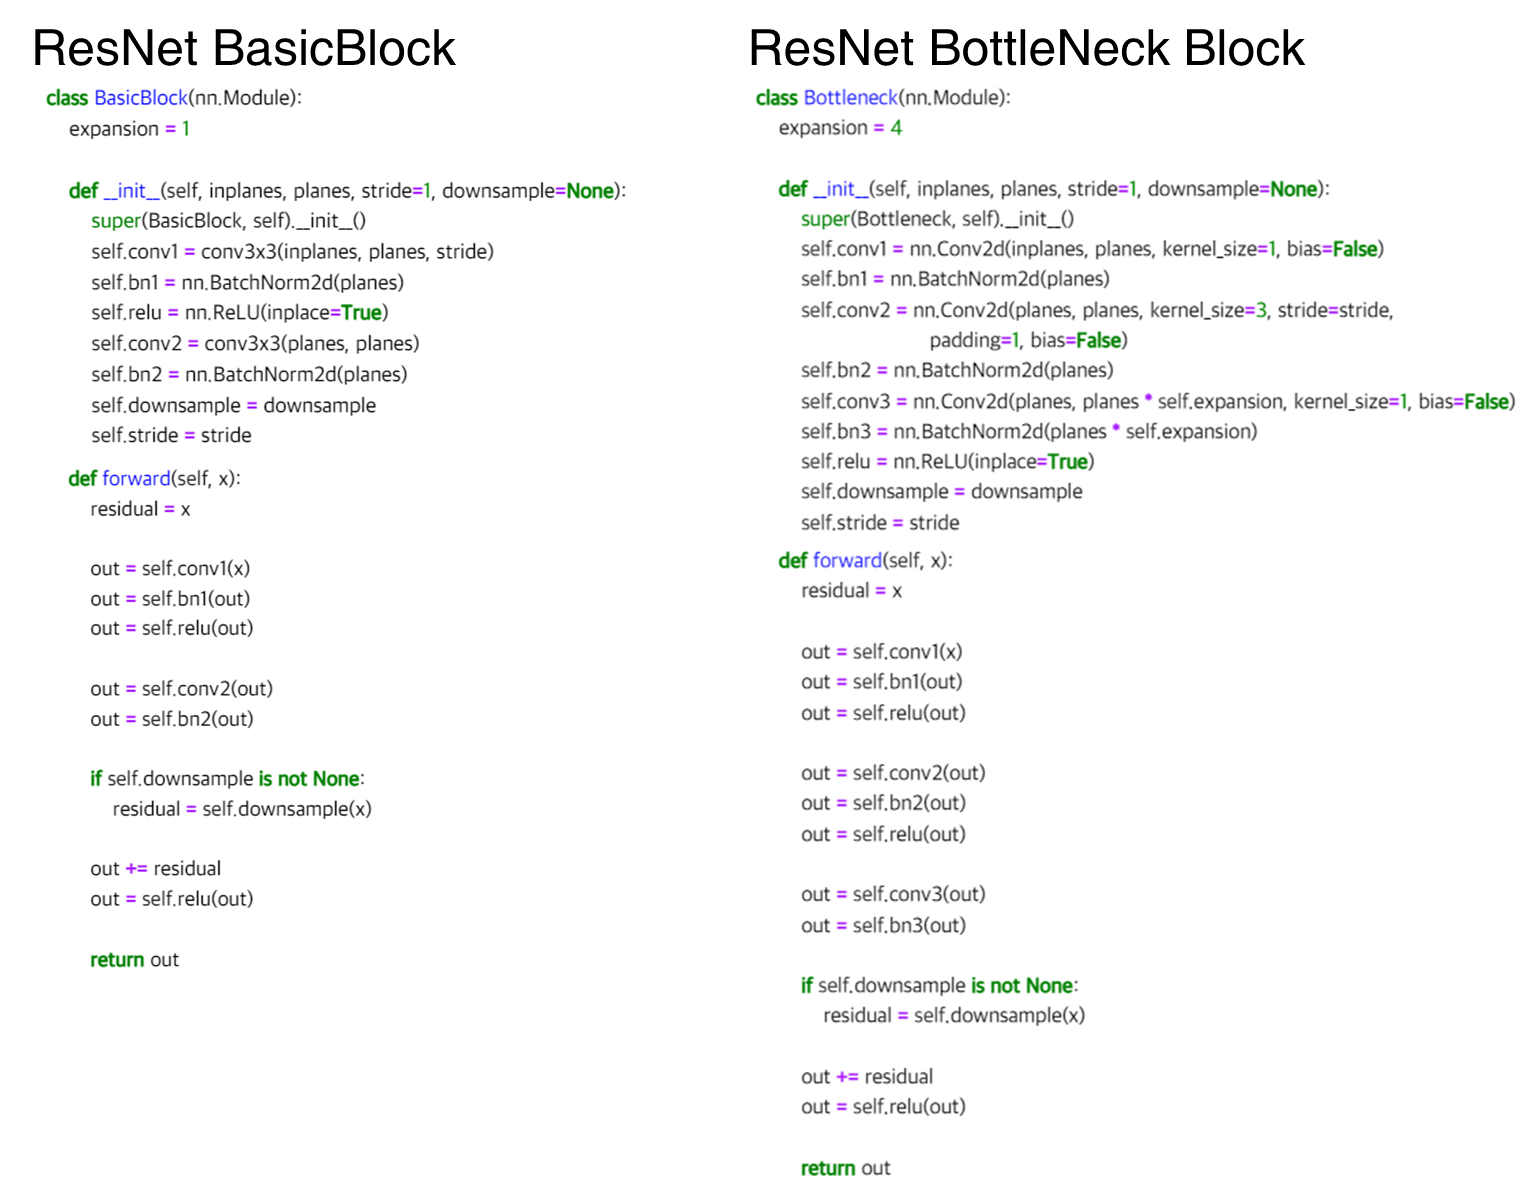</img>

**02. PSPNet.py**

``` python
import torch
from torch import nn
import torch.nn.functional as F
import model.resnet as models
````

**1) Pyramid Parsing Module**
<img src= "https://user-images.githubusercontent.com/75057952/158048952-ab32adea-be52-4b6c-9002-0265308afa79.png" width = "700dp"></img>
**2) ResNet to PSPNet**
<img src= "https://user-images.githubusercontent.com/75057952/158048957-b47d28f3-7168-4a34-a228-e475778cc40e.png" width = "800dp"></img>
<img src= "https://user-images.githubusercontent.com/75057952/158048959-0fd8428b-17eb-4ed6-ae2f-b39761a0d963.png" width = "800dp"></img>
---
- Auxiliary moduel는 segmentation task를 수행하는 것이 아니라 simple classifier
- 전체적인 학습을 보조하는 효과가 있음

<img src = "https://user-images.githubusercontent.com/75057952/158048962-f02a9304-4a73-41dc-8e25-f7e0abff516d.png" width = "400dp"></img>

<img src = "https://user-images.githubusercontent.com/75057952/158048969-c0b8594f-f3a6-4499-8602-726eae6e55c9.png" width = "800dp"></img>
- ```segmentation loss```는 ```NLLLoss2d()``` loss (Cross entropy loss는 softmax를 적용한 뒤 loss를 측정하는 것에 비해, NLLLoss는 softmax를 적용하지 않음)
- ```classification loss```는 ```BCEWithLogitsLoss()``` (Cross entropy에서 softmax 대신 sigmoid를 사용함)
- 총 loss는 ```segmentation loss```에 $alpha(=0.4) \times$ ```classification loss```를 더한 값